# Refraction Traveltime Tomography - shooting rays

### Author: M.Ravasi

This notebook creates the machinery to define a geometry, shoot rays, and extract those rays corresponding to available pairs of sources and receivers.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from scipy.signal import filtfilt
from refrtomo.raytrace import raytrace
from refrtomo.survey import *
from refrtomo.tomomatrix import *

## Velocity model

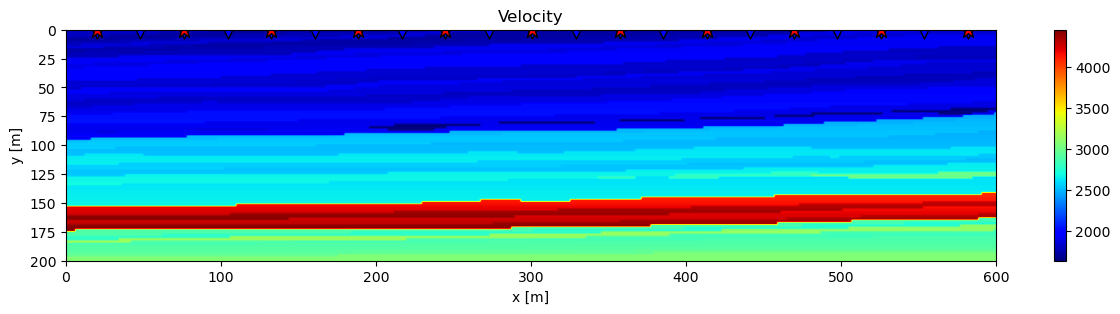

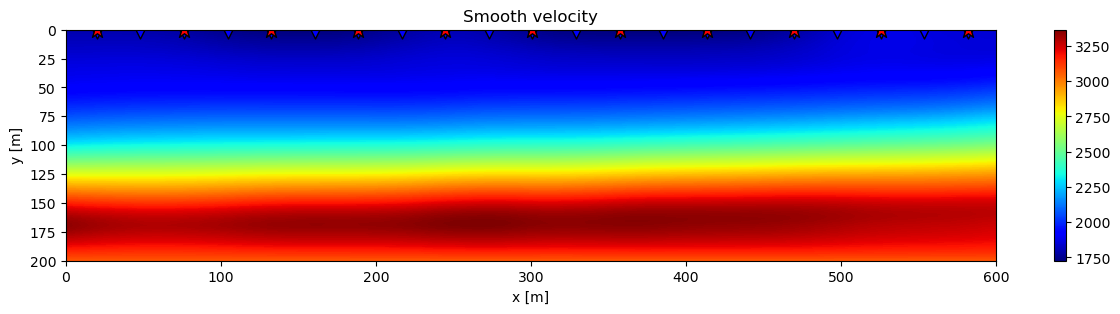

In [2]:
# Velocity model
nx, nz = 1360, 280
dx, dz = 2., 2.

vel_true = np.fromfile("../data/marmousi.bin", dtype='float32', sep="") 
vel_true = vel_true.reshape(nx, nz)[100:401, 100:201]
nx, nz = vel_true.shape
x, z = np.arange(nx) * dx, np.arange(nz) * dz

# Smooth velocity
nsmooth = 30
vel_sm = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, vel_true, axis=0)
vel_sm = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, vel_sm, axis=1)

#[zz, xx]= np.meshgrid(z, x, indexing='ij')
#vel_sm = 1000 + 4. * zz.T

# Receivers
nr = 21
rx = np.linspace(dx*10, (nx-10)*dx, nr)
rz = 0*np.ones(nr)
recs = np.vstack((rx, rz))
dr = recs[0,1]-recs[0,0]

# Sources
ns = 11
sx = np.linspace(dx*10, (nx-10)*dx, ns)
sz = 0*np.ones(ns)
sources = np.vstack((sx, sz))
ds = sources[0,1]-sources[0,0]

plt.figure(figsize=(15, 3))
im = plt.imshow(vel_true.T, cmap='jet', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(recs[0],  recs[1], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(sources[0], sources[1], marker='*', s=150, c='r', edgecolors='k')
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]')
plt.title('Velocity')
plt.ylim(z[-1], z[0])

plt.figure(figsize=(15, 3))
im = plt.imshow(vel_sm.T, cmap='jet', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(recs[0], recs[1], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(sources[0], sources[1], marker='*', s=150, c='r', edgecolors='k')
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]')
plt.title('Smooth velocity')
plt.ylim(z[-1], z[0]);

## Survey geometry

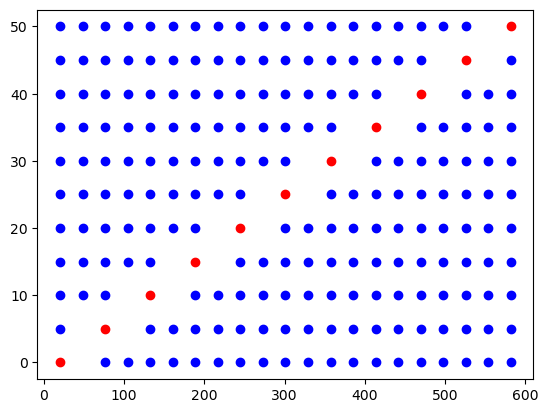

In [3]:
srcs = np.vstack((sx, sz))
recs = np.vstack((rx, rz))

survey = survey_geom(srcs, recs, minoffset=50)
display_survey(survey)

## Raytrace (one source)

raytrace: 1800 Shot rays, 442 Turning rays...


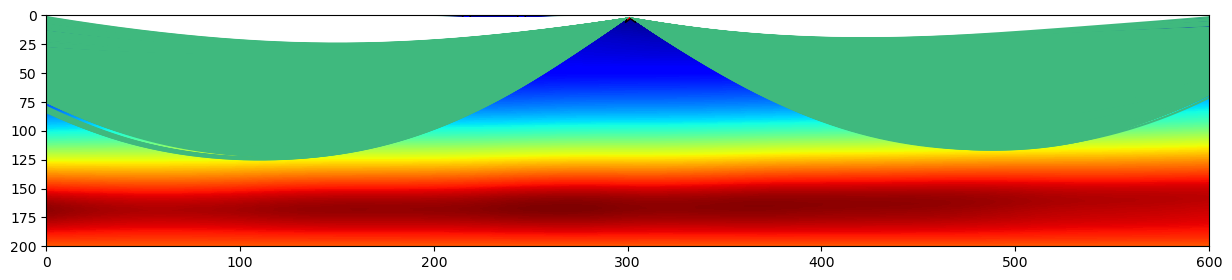

In [4]:
# Take off angles
thetas = np.hstack([np.arange(-85, -40, 0.05), np.arange(40, 85, 0.05)])

# Length vector
lmax = 1e3
nl = 2000

# Raytrace
rays, rays_turning, thetas_turning = raytrace(vel_sm.T, x, z, dx, dz, 
                                              lmax, nl, survey[ns//2].src, 
                                              thetas, dzout=1., debug=True)

plt.figure(figsize=(15, 3))
plt.imshow(vel_sm.T, cmap='jet', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(survey[ns//2].rec[0], survey[ns//2].rec[1], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(survey[ns//2].src[0], survey[ns//2].src[1], marker='*', s=150, c='r', edgecolors='k')
for ray in rays:
    plt.plot(ray[:,0], ray[:,1], '#3FB97E')
for ray in rays_turning:
    plt.plot(ray[:,0], ray[:,1], 'w')
plt.axis('tight');

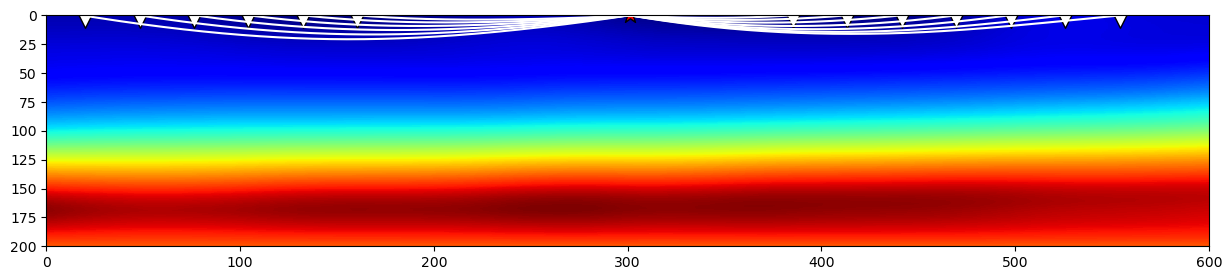

In [5]:
# Assign receivers to rays
plt.figure(figsize=(15, 3))
plt.imshow(vel_sm.T, cmap='jet', extent = (x[0], x[-1], z[-1], z[0]))

ray_rec_mindistance = 1.
irecs = []
for irec, rec in enumerate(survey[ns//2].rec.T):
    rays_endx = np.array([ray[-1, 0] for ray in rays_turning])
    iray = np.argmin(np.abs(rays_endx - rec[0]))
    ray_rec_distance = rays_endx[iray] - rec[0]
    if np.abs(ray_rec_distance) < ray_rec_mindistance:
        irecs.append(irec)
        plt.plot(rays_turning[iray][:,0], rays_turning[iray][:,1], 'w')
plt.scatter(survey[ns//2].src[0], survey[ns//2].src[1], marker='*', s=150, c='r', edgecolors='k')
plt.scatter(survey[ns//2].rec[0, irecs], survey[ns//2].rec[1, irecs]+2, 
            marker='v', s=200, c='w', edgecolors='k')
plt.axis('tight');

## Raytrace all sources

survey_raytrace: 200 Source-receiver pairs in survey, 147 Source-receiver paired with ray...


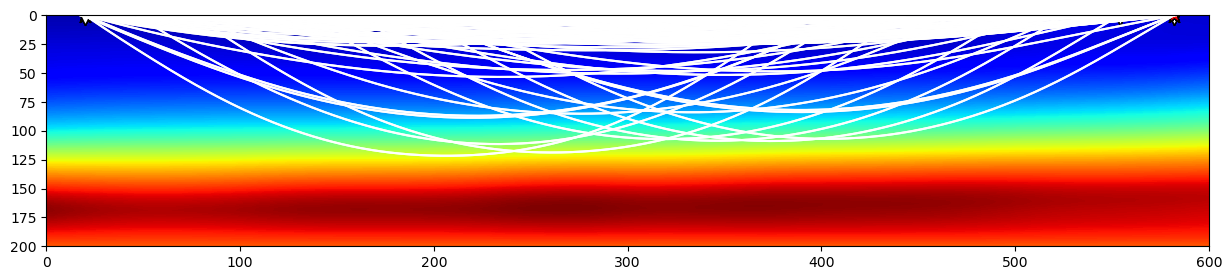

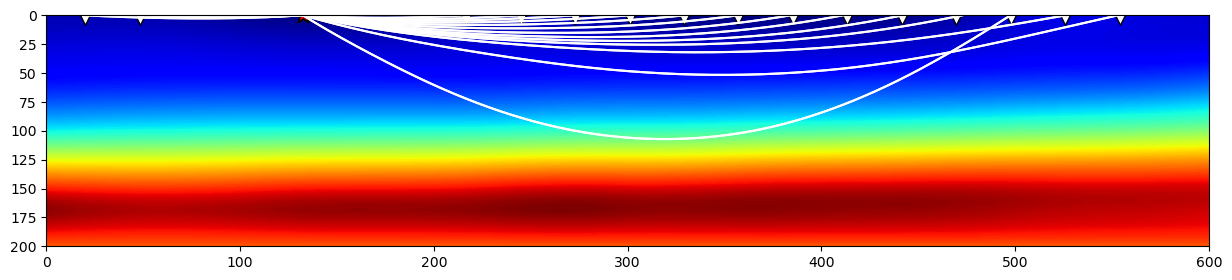

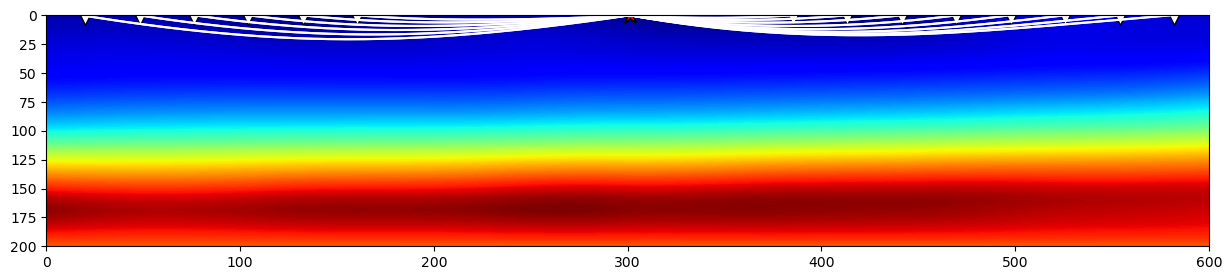

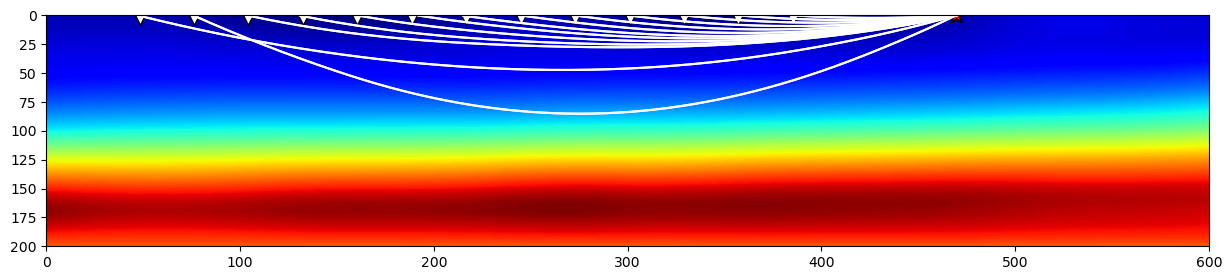

In [6]:
# Trace all rays
avasurvey = survey_raytrace(survey, vel_sm.T, x, z, lmax, nl, thetas, dzout=5., ray_rec_mindistance=5., debug=True)

# Display rays
display_survey_rays(avasurvey, vel_sm.T, x, z, figsize=(15, 3))
display_survey_rays(avasurvey, vel_sm.T, x, z, sx=sx[ns//4], figsize=(15, 3))
display_survey_rays(avasurvey, vel_sm.T, x, z, sx=sx[ns//2], figsize=(15, 3))
display_survey_rays(avasurvey, vel_sm.T, x, z, sx=sx[3*ns//4], figsize=(15, 3))

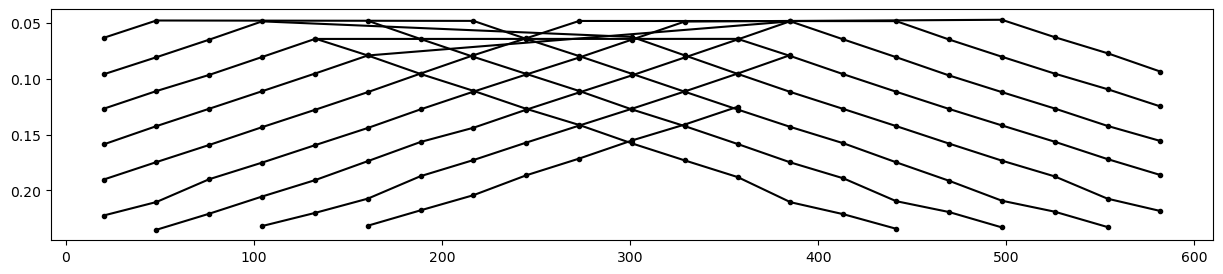

In [7]:
# Display observed traveltimes
fig, ax = plt.subplots(1, 1, figsize=(15, 3))
for isrc in range(ns):
    display_survey_tobs(avasurvey, sx[isrc], ax=ax)

## Create tomographic matrix

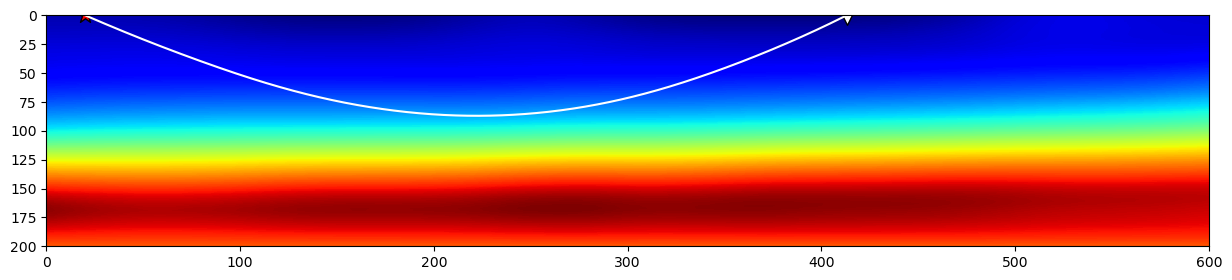

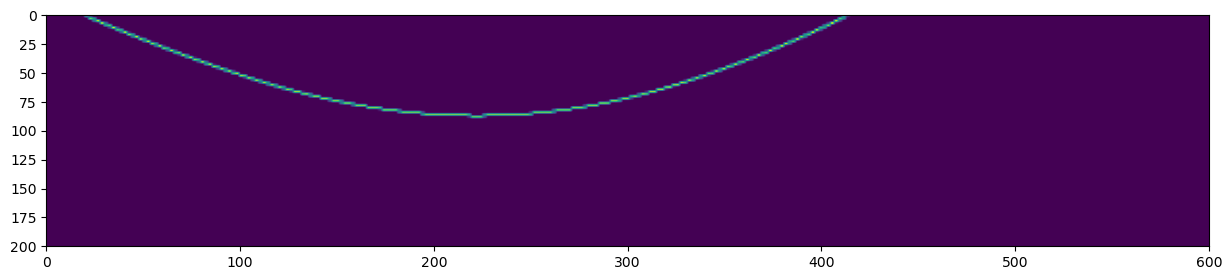

In [8]:
# single ray
iray = 10

R = [raytrace_straight(avasurvey[iray].ray[i], avasurvey[iray].ray[i+1], dx, dz, 0., 0., nx, nz, x, z)[0] 
     for i in range(avasurvey[iray].ray.shape[0]-1)]
R = np.sum(R, axis=0)

plt.figure(figsize=(15, 3))
plt.imshow(vel_sm.T, cmap='jet', extent = (x[0], x[-1], z[-1], z[0]))

plt.plot(avasurvey[iray].ray[:,0], avasurvey[iray].ray[:,1], 'w')
plt.scatter(avasurvey[iray].src[0], avasurvey[iray].src[1], marker='*', s=150, c='r', edgecolors='k')
plt.scatter(avasurvey[iray].rec[0], avasurvey[iray].rec[1], marker='v', s=200, c='w', edgecolors='k')
plt.axis('tight');

plt.figure(figsize=(15, 3))
plt.imshow(R.reshape(nx, nz).T, extent = (x[0], x[-1], z[-1], z[0]))
plt.axis('tight');

In [9]:
tobs = extract_tobs(avasurvey)[iray]
tobs_R = R @ (1/vel_sm.ravel())

tobs, tobs_R

(0.22129921778831735, 0.22035780388040363)

(20, 30401)


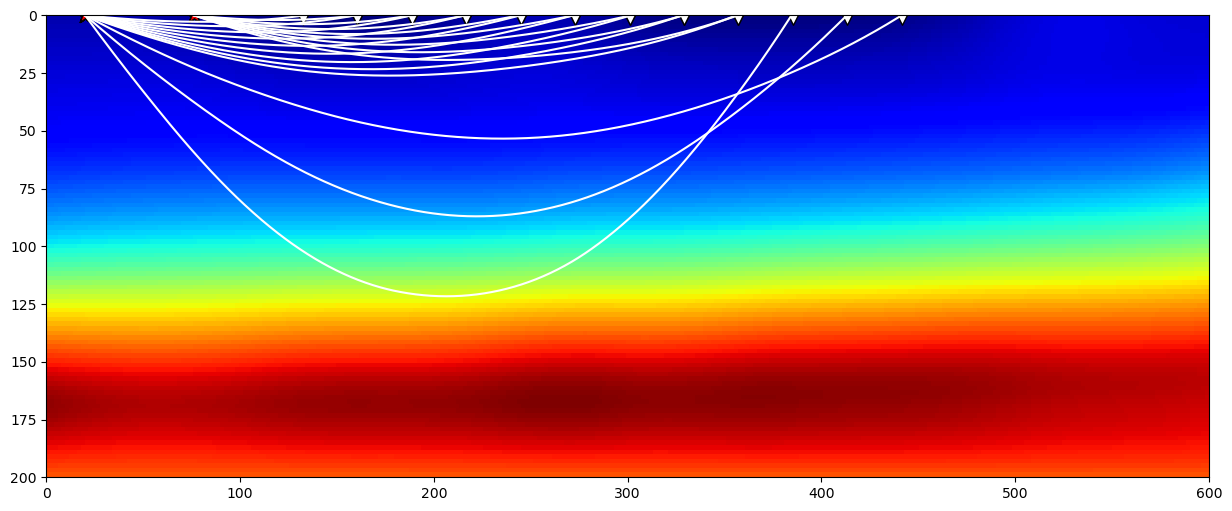

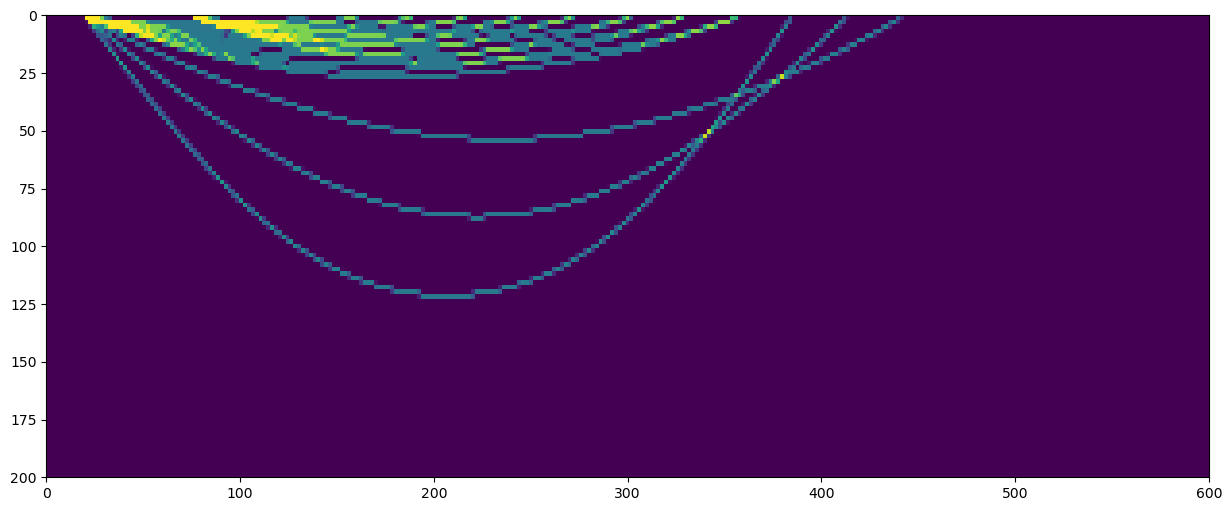

In [10]:
# multiple rays
iraymax = 20

R = []
Rcove = np.zeros(nx*nz)
for ray in avasurvey[:iraymax]:
    R_ = [raytrace_straight(ray.ray[i], ray.ray[i+1], dx, dz, 0., 0., nx, nz, x, z)[0] 
         for i in range(ray.ray.shape[0]-1)]
    R.append(np.sum(R_, axis=0))
    Rcove = Rcove + np.sum(R_, axis=0)
R = np.vstack(R)
print(R.shape)

plt.figure(figsize=(15, 6))
plt.imshow(vel_sm.T, cmap='jet', extent = (x[0], x[-1], z[-1], z[0]))

for ray in avasurvey[:iraymax]:
    plt.plot(ray.ray[:,0], ray.ray[:,1], 'w')
    plt.scatter(ray.src[0], ray.src[1], marker='*', s=150, c='r', edgecolors='k')
    plt.scatter(ray.rec[0], ray.rec[1], marker='v', s=200, c='w', edgecolors='k')
    plt.axis('tight');

plt.figure(figsize=(15, 6))
plt.imshow(Rcove.reshape(nx, nz).T, vmin=0, vmax=5, extent = (x[0], x[-1], z[-1], z[0]))
plt.axis('tight');

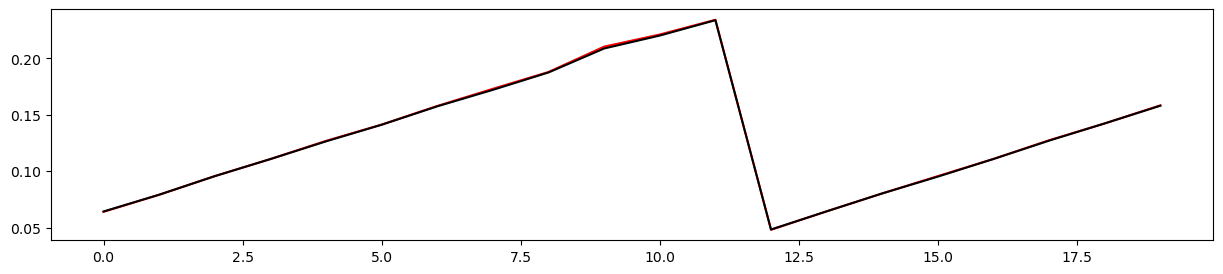

In [11]:
tobs = extract_tobs(avasurvey)
tobs_R = R @ (1/vel_sm.ravel())

plt.figure(figsize=(15, 3))
plt.plot(tobs[:iraymax], 'r')
plt.plot(tobs_R, 'k');

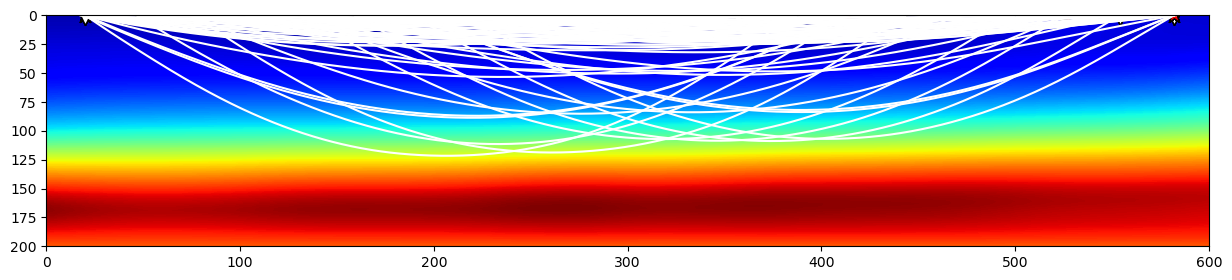

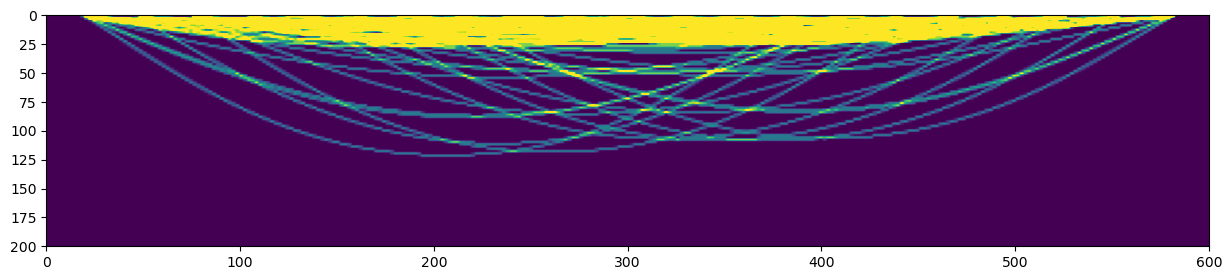

In [12]:
# all rays
R = []
Rcove = np.zeros(nx*nz)
for ray in avasurvey:
    R_ = [raytrace_straight(ray.ray[i], ray.ray[i+1], dx, dz, 0., 0., nx, nz, x, z)[0] 
         for i in range(ray.ray.shape[0]-1)]
    R.append(np.sum(R_, axis=0))
    Rcove = Rcove + np.sum(R_, axis=0)
R = np.vstack(R)

plt.figure(figsize=(15, 3))
plt.imshow(vel_sm.T, cmap='jet', extent = (x[0], x[-1], z[-1], z[0]))

for ray in avasurvey:
    plt.plot(ray.ray[:,0], ray.ray[:,1], 'w')
    plt.scatter(ray.src[0], ray.src[1], marker='*', s=150, c='r', edgecolors='k')
    plt.scatter(ray.rec[0], ray.rec[1], marker='v', s=200, c='w', edgecolors='k')
    plt.axis('tight');

plt.figure(figsize=(15, 3))
plt.imshow(Rcove.reshape(nx, nz).T, vmin=0, vmax=5, extent = (x[0], x[-1], z[-1], z[0]))
plt.axis('tight');

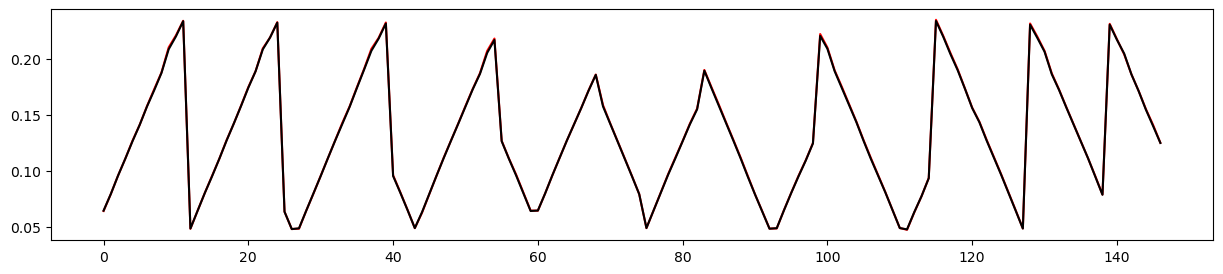

In [13]:
tobs = extract_tobs(avasurvey)
tobs_R = R @ (1/vel_sm.ravel())

plt.figure(figsize=(15, 3))
plt.plot(tobs, 'r')
plt.plot(tobs_R, 'k');

tomographic_matrix: 147 rows, 30401 columns


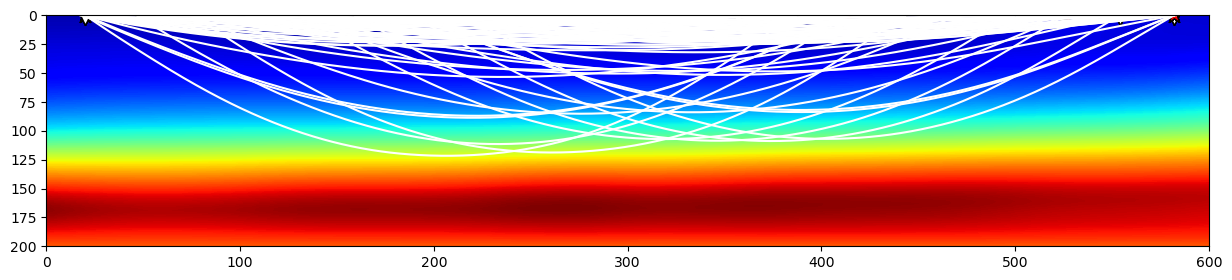

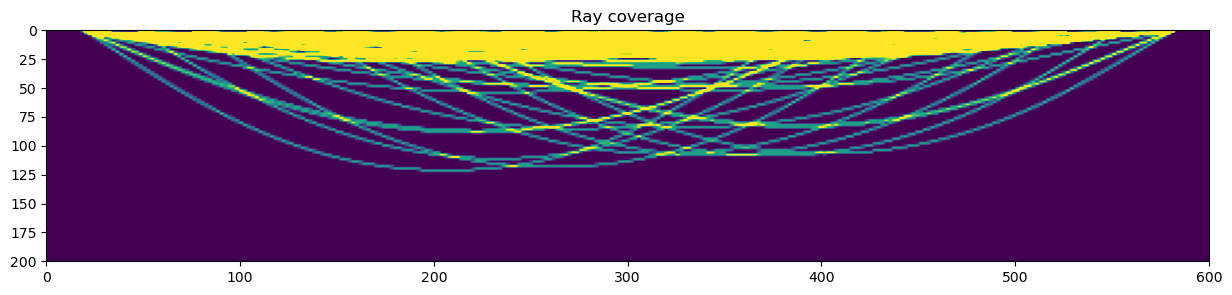

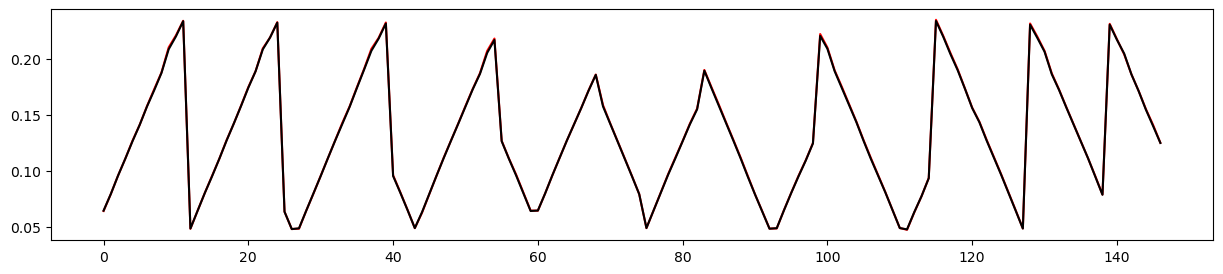

In [14]:
R = tomographic_matrix(avasurvey, dx, dz, 0, 0, nx, nz, x, z, 
                       debug=True, plotflag=True, vel=vel_sm, figsize=(15, 3))

tobs = extract_tobs(avasurvey)
tobs_R = R @ (1/vel_sm.ravel())

plt.figure(figsize=(15, 3))
plt.plot(tobs, 'r')
plt.plot(tobs_R, 'k');